I have decided to complete the task in a Jupyter Notebook, which allows me to provide additional notes along with the code. This is aimed at making the analysis more transparent and easier to understand/follow.
 


<img src="qantas_logo2.png">

# Sydney to Los Angeles traffic 



In [38]:
# Set up imports required
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
from pylab import rcParams




In [39]:
# Read the data into a dataframe
data = pd.read_excel("International_airline_activity_CityPairs_2009toCurrent_1811.xlsx", 
                     sheet_name="Data",na_values = ['.'])
#list(data.columns)

## Limitations of the data
The BITRE data notes indicate there is effectively two definitions of passengers ranging across two periods. Prior to 2000, any passenger paying 25% of the full fare is considered a revenue passenger, however after this period, any passenger paying a fair, inclusing less than 25% and frequent flier redemption, is considered a revenue passenger.

I will ignore this seperation in passenger definition to simplify the analysis. 


## Data Filtering
Select the data we want and filter by the locations, Sydney and Los Angeles.

In [40]:
data = data[['Month','AustralianPort','ForeignPort','PaxOut']]
PassengerData = data[(data['AustralianPort'] == 'Sydney') & 
                     (data['ForeignPort'] == 'Los Angeles')]

# Convert the data types
PassengerData['PaxOut'] = PassengerData['PaxOut'].astype('int64')
PassengerData.rename(columns={'Month': 'Date'}, inplace=True)
# Reset the index
PassengerData = PassengerData.set_index('Date')


In [41]:
# Take a look at the data
PassengerData.head()

,AustralianPort,ForeignPort,PaxOut
Date,,,
2009-01-01,Sydney,Los Angeles,22603
2009-02-01,Sydney,Los Angeles,17870
2009-03-01,Sydney,Los Angeles,25717
2009-04-01,Sydney,Los Angeles,28520
2009-05-01,Sydney,Los Angeles,27490


In [5]:
# Check for null values in the data
PassengerData.isnull().sum()

AustralianPort    0
ForeignPort       0
PaxOut            0
dtype: int64

### Notes:
With a larger sample, we would want to confirm the sampling rate is constant, but we can visually check this with the current data of only 119 samples.

I checked this using the excel spreadsheet and filtered for the Sydney and Los Angeles locations.

In [6]:
# Summarize the data we have, this will only affect the PaxOut value, as this is the only numerical value.
PassengerData.describe()

,PaxOut
count,119.000000
mean,36657.302521
std,4840.042023
min,17870.000000
25%,34135.000000
50%,37065.000000
75%,39705.500000
max,51005.000000


# Exploratory Analysis
First we want to visualise the data, to see if we can see anything obvious. We can then decompose the data into expected compositions.

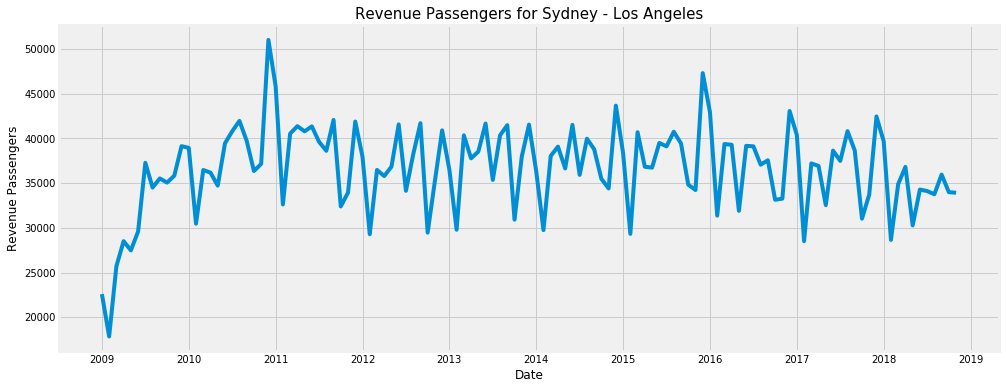

In [7]:
PassengerData['PaxOut'].plot(figsize=(15, 6))
plt.ylabel('Revenue Passengers')
plt.title('Revenue Passengers for Sydney - Los Angeles',fontsize=15)
plt.show()

There is an unusual affect at the beginning of the data set indicating rapid increase in passengers throughout 2009. Without knowing too much about the data, I think this period should be excluded to avoid influencing the forecasting.

There are also two significant peaks at the end of 2011 and 2015. It would be interesting to try to determine why these spikes occured, but this is outside the scope of the task.

In [8]:
# Remove the first 12 rows of the data (all data from 2009)
PassengerData = PassengerData.iloc[12:]

# Seasonal Decomposition

If we assume that the data can be represented by a number of additive components, we can decompose the data into the 'Trend', 'Seasonality', and 'Noise'

The statsmodel library provides for [seasonal decomposition] of time series data.

[seasonal decomposition]:(https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html#statsmodels.tsa.seasonal.seasonal_decompose)


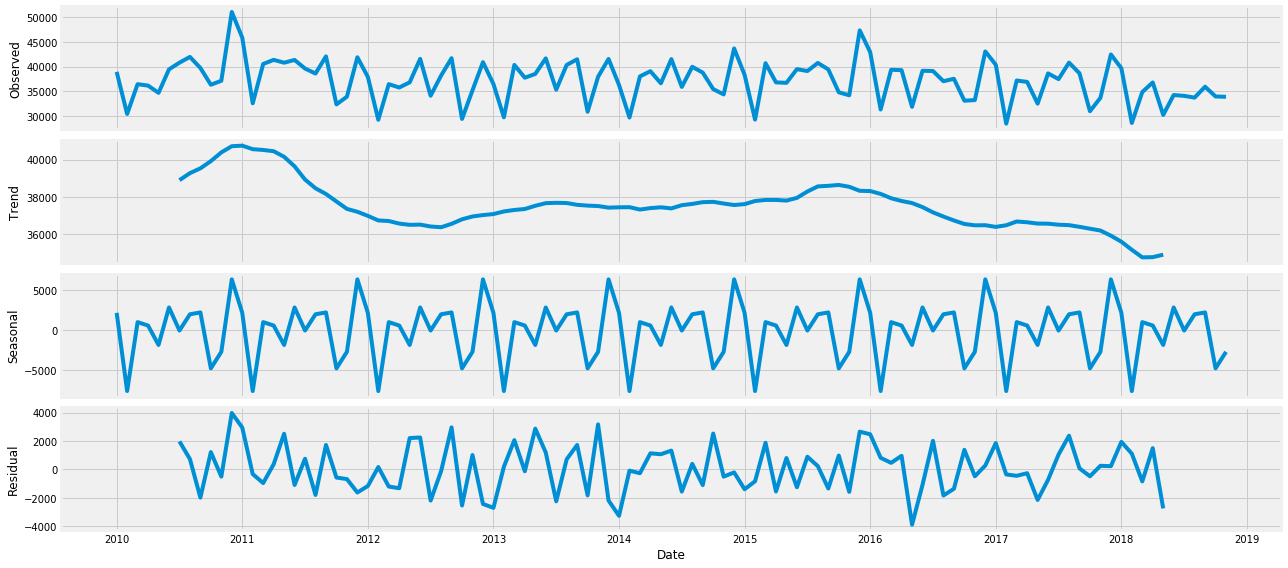

In [9]:
rcParams['figure.figsize'] = 18, 8

# We assume that the data can be described by a number of additive components
decomposition = sm.tsa.seasonal_decompose(PassengerData['PaxOut'], model='additive')
fig = decomposition.plot()
plt.show()

In [29]:
# Generate potential values for the seasonal, trend and noise parameters for the
# ARIMA model to perform grid search

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [30]:
# Perform the grid search
warnings.filterwarnings("ignore") # specify to ignore warning messages

min_aic = 99999999

for parameters in pdq:
    for seasonal_parameters in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(PassengerData['PaxOut'],
                                            order=parameters, 
                                            seasonal_order=seasonal_parameters,
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False)

            results = mod.fit()

            if results.aic < min_aic:
                min_aic = results.aic
                params = parameters
                seasonal = seasonal_parameters
            
        except:
            continue
            # Some parameter combinations may lead to numerical misspecifications, which 
            # can also lead to errors and throw an exception, so we make sure to catch these exceptions.
            
print ('Optimal parameters {} x {} - AIC: {}'.format(params, seasonal, min_aic))


Optimal parameters (1, 1, 1) x (1, 1, 1, 12) - AIC: 1468.491047523315


# Fit a model with the optimial parameters
We have now determined the optimal parameters to use, so we fit a model and check some basic model statistics to verify a reasonable model behaviour.

In [31]:
mod = sm.tsa.statespace.SARIMAX(PassengerData['PaxOut'],
                                order=params,
                                seasonal_order=seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0771      0.129     -0.598      0.550      -0.330       0.176
ma.L1         -0.7964      0.073    -10.898      0.000      -0.940      -0.653
ar.S.L12       0.0648      0.138      0.471      0.638      -0.205       0.334
ma.S.L12      -0.4166      0.177     -2.359      0.018      -0.763      -0.070
sigma2      4.806e+06   7.36e+05      6.534      0.000    3.36e+06    6.25e+06


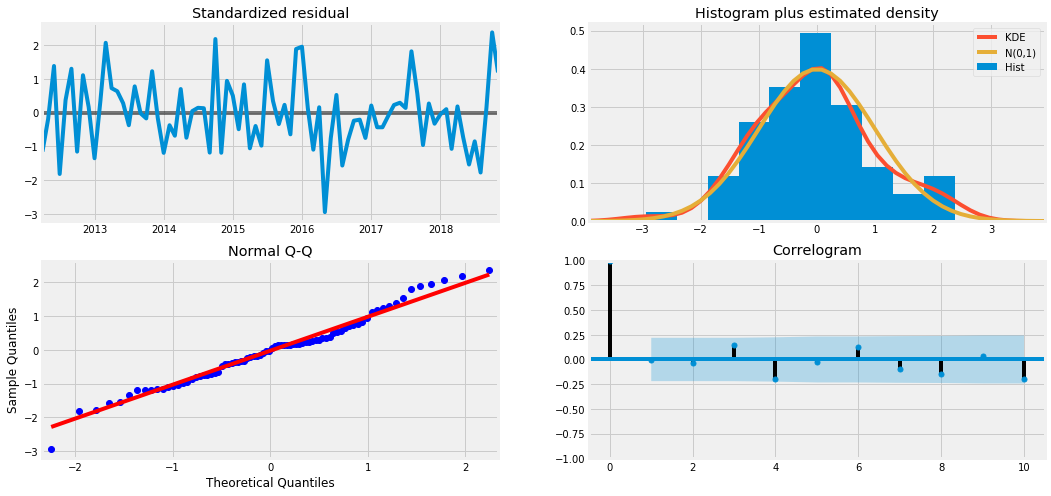

In [32]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

- Top Left: We want to see that there is no seasonality or general trend, this should represnet random noise.

- Top Right: We want to see that the histogram has a Normal distribution, also the KDE line follows the standard definition of a Normal distribution, represented by N(0,1).

- Bottom Left: We wont to see that the blue dots follow the linear trend line. 

- Bottom Right: We want to see that the time series residuals have a low correlation with the lagged version of itself. This is shown by the residuals being within the blue shaded region and the bounds of the blue shaded region are small.

We would like the correlogram to be constrained more, but we can conclude that the model will produce a reasonable fit to the data. 

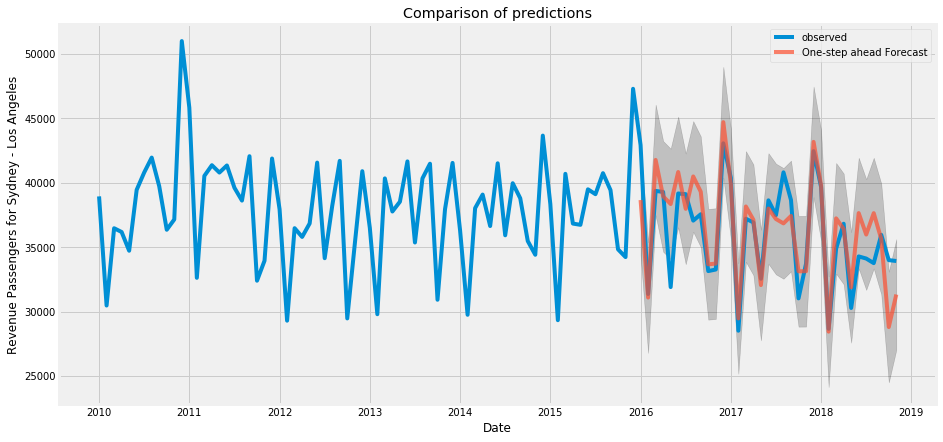

In [33]:
# Make some predictions from 2016 onwards and compare to actual data
predictions = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
predictions_confidence = predictions.conf_int()

ax = PassengerData['PaxOut'].plot(label='Observed')
predictions.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(predictions_confidence.index,
                predictions_confidence.iloc[:, 0],
                predictions_confidence.iloc[:, 1], color='k', alpha=.2)

ax.set_title('Comparison of predictions')
ax.set_xlabel('Date')
ax.set_ylabel('Revenue Passengers for Sydney - Los Angeles')
plt.legend()

plt.show()

The forcasts match the observations reasonably well.

In [34]:
forecasted = predictions.predicted_mean
truth = PassengerData['PaxOut']['2016-01-01':]

mse = ((forecasted - truth) ** 2).mean()
#print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
rmse = np.sqrt(mse)
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse,2)))

The Root Mean Squared Error of our forecasts is 2300.25


To determine if the RMSE value is a large or small number, we compare it to the range of values that we are trying to predict.

In [35]:
PassRange = PassengerData['PaxOut'].max() - PassengerData['PaxOut'].min()
print ('The RMSE is {}% of revenue passanger scale'.format(round(rmse/PassRange *100),2))

The RMSE is 10.0% of revenue passanger scale


This indicates that we will have a reasonable value for the prediction compared to what the actual value will be.


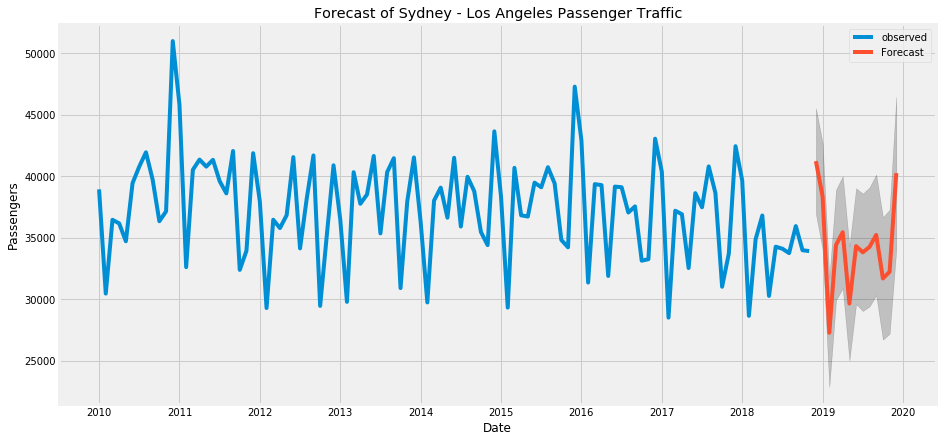

In [36]:
future_prediction = results.get_forecast(steps=13)
predictions_confidence = future_prediction.conf_int()

ax = PassengerData['PaxOut'].plot(label='Observed', figsize=(14, 7))
future_prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(predictions_confidence.index,
                predictions_confidence.iloc[:, 0],
                predictions_confidence.iloc[:, 1], color='k', alpha=.2)
ax.set_title('Forecast of Sydney - Los Angeles Passenger Traffic')
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')

plt.legend()
plt.show()

In [37]:
# Print the predictions of each month in 2019 to the console.
print (round(future_prediction.predicted_mean,2))

2018-12-01    41243.14
2019-01-01    38367.03
2019-02-01    27288.96
2019-03-01    34418.06
2019-04-01    35464.69
2019-05-01    29664.33
2019-06-01    34334.40
2019-07-01    33830.36
2019-08-01    34265.44
2019-09-01    35243.56
2019-10-01    31704.04
2019-11-01    32247.64
2019-12-01    40270.39
Freq: MS, dtype: float64
